In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import swifter

from cnv_profile import CNV_Profile
from plot_cnv_profile import plot_acr_static

In [88]:
import importlib
import cnv_profile
importlib.reload(cnv_profile)
from cnv_profile import CNV_Profile

In [89]:
default_profile = CNV_Profile(num_subclones=3, csize='../cnv_data/genome.hg38.txt', cent_loc=centromere_spec_df.to_dict()['avg'])
default_profile.add_cnv_events(arm_num=10, focal_num=100, p_whole=0.6, ratio_clonal=0.5,
                       median_focal_length=1.8 * 10**6)
default_profile.add_arm(2, 1, chrom='1')
default_profile.calculate_cnv_profile()
default_profile.calculate_df_profiles()

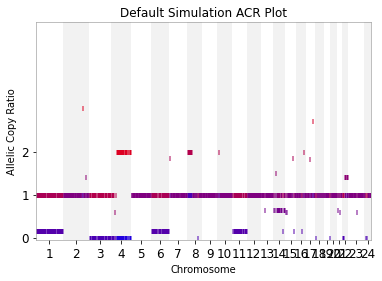

In [90]:
import plot_cnv_profile
import importlib
importlib.reload(plot_cnv_profile)
from plot_cnv_profile import plot_acr_static

fig, ax = plt.subplots()
plot_acr_static(default_profile.cnv_profile_df, ax, default_profile.csize, segment_colors='difference')


In [101]:
# Generate test binned coverage profile (for WGS)

test_binned_coverage = pd.read_csv('../cnv_data/1Mb.genome_bins.hg38.bed', sep='\t', header=None, names=['chrom', 'start_pos', 'end_pos'])

dispersion_norm = np.random.normal(0, 10, test_binned_coverage.shape[0])
binned_coverage = 30 * (test_binned_coverage['end_pos'] - test_binned_coverage['start_pos'])
# this_chr_coverage = np.asarray([np.random.poisson(cov + np.exp(disp)) for cov, disp in
#                                zip(binned_coverage, dispersion_norm)])  # would need to calculate sum of binned log NP 
this_chr_coverage = np.random.poisson(binned_coverage)
test_binned_coverage['cov'] = this_chr_coverage
test_binned_coverage['chrom'] = test_binned_coverage['chrom'].apply(lambda x: x[3:])
test_binned_coverage.to_csv('./test/simulation/binned_coverage.test', sep='\t', index=False)

In [102]:
# SAVE COVERAGE FILE

default_profile.save_coverage_file('./test/simulation/test_coverage.txt', 0.7, './test/simulation/binned_coverage.test') #'../HapASeg/simulation/NA12878/VCF/binned_coverage.bed')


In [107]:
# Generate test VCF file with depth

test_vcf = pd.read_csv('../HapASeg/simulation/NA12878/VCF/NA12878.vcf', sep='\t', comment='#', header=None, 
                     names=['CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','NA12878'])
test_vcf = test_vcf[['CHROM', 'POS']].rename(columns={'CHROM': 'chr', 'POS': 'pos'})

dispersion_norm = np.random.normal(0, 2, test_vcf.shape[0])
this_chr_coverage = np.asarray([np.random.poisson(30 + np.exp(disp)) for disp in dispersion_norm])
test_vcf['depth'] = this_chr_coverage
test_vcf['chr'] = test_vcf['chr'].apply(lambda x: x[3:])
test_vcf.to_csv('./test/simulation/test_hets.txt', sep='\t', index=False)

In [108]:
# SAVE HETS FILE
default_profile.save_hets_file('./test/simulation/test_hets.counts.txt', '../HapASeg/simulation/NA12878/VCF/NA12878.vcf', './test/simulation/test_hets.txt', 0.7)


In [110]:
test_hets_file = pd.read_csv('./test/simulation/test_hets.counts.txt', sep='\t')
test_hets_file[(test_hets_file['REF_COUNT'] > 0) & (test_hets_file['ALT_COUNT'] > 0)]

/home/cmesser/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CONTIG,POSITION,REF_COUNT,ALT_COUNT
2,1,740738,14,12
6,1,770502,20,12
20,1,789680,12,10
22,1,792149,11,18
26,1,797392,16,19
...,...,...,...,...
4167805,X,155443920,11,8
4167834,X,155522299,21,15
4167846,X,155532668,14,12
4167885,X,155554981,13,10


## Get cytobands

In [16]:
import sys
sys.path.append('/home/cmesser/HapASeg')
from hapaseg.utils import parse_cytoband

In [24]:
cband = pd.read_csv('../cnv_data/cytoBand.hg38.txt', sep = "\t", names = ["chr", "start", "end", "band", "stain"])
cband

,chr,start,end,band,stain
0,chr1,0,2300000,p36.33,gneg
1,chr1,2300000,5300000,p36.32,gpos25
2,chr1,5300000,7100000,p36.31,gneg
3,chr1,7100000,9100000,p36.23,gpos25
4,chr1,9100000,12500000,p36.22,gneg
...,...,...,...,...,...
857,chrY,12400000,17100000,q11.221,gpos50
858,chrY,17100000,19600000,q11.222,gneg
859,chrY,19600000,23800000,q11.223,gpos50
860,chrY,23800000,26600000,q11.23,gneg


In [75]:
centromere_df = parse_cytoband('../cnv_data/cytoBand.hg38.txt')
centromere_df.loc[centromere_df[centromere_df['start'] == 0].index, 'arm'] = 'p'
centromere_df.loc[centromere_df[centromere_df['start'] != 0].index, 'arm'] = 'q'


centromere_spec_df = centromere_df.set_index(['chr', 'arm']).unstack()[[('start', 'q'), ('end', 'p')]]
centromere_spec_df['avg'] = centromere_spec_df.mean(axis=1).astype(int)
centromere_spec_df['list'] = centromere_spec_df.apply(lambda x: [int(x[('end', 'p')]), int(x[('start', 'q')])], axis=1)
centromere_spec_df.columns = centromere_spec_df.columns.droplevel(1)
centromere_spec_df.index = centromere_spec_df.index.map(str)

In [74]:
centromere_spec_df.index.map(str)

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object', name='chr')

In [76]:
centromere_spec_df.to_dict()['avg']

{'1': 123400000,
 '2': 93900000,
 '3': 90900000,
 '4': 50000000,
 '5': 48750000,
 '6': 60550000,
 '7': 60100000,
 '8': 45200000,
 '9': 43850000,
 '10': 39800000,
 '11': 53400000,
 '12': 35500000,
 '13': 17700000,
 '14': 17150000,
 '15': 19000000,
 '16': 36850000,
 '17': 25050000,
 '18': 18450000,
 '19': 26150000,
 '20': 28050000,
 '21': 11950000,
 '22': 15550000,
 '23': 60950000,
 '24': 10450000}

In [77]:
centromere_spec_df.to_dict()['list']

{'1': [121700000, 125100000],
 '2': [91800000, 96000000],
 '3': [87800000, 94000000],
 '4': [48200000, 51800000],
 '5': [46100000, 51400000],
 '6': [58500000, 62600000],
 '7': [58100000, 62100000],
 '8': [43200000, 47200000],
 '9': [42200000, 45500000],
 '10': [38000000, 41600000],
 '11': [51000000, 55800000],
 '12': [33200000, 37800000],
 '13': [16500000, 18900000],
 '14': [16100000, 18200000],
 '15': [17500000, 20500000],
 '16': [35300000, 38400000],
 '17': [22700000, 27400000],
 '18': [15400000, 21500000],
 '19': [24200000, 28100000],
 '20': [25700000, 30400000],
 '21': [10900000, 13000000],
 '22': [13700000, 17400000],
 '23': [58100000, 63800000],
 '24': [10300000, 10600000]}